In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function
)
import numpy as np
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook

In [4]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.PoissonOperator import PoissonBracket

In [5]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# General

We  start by considering the following lattice:
$$A-B-C-D-E$$
where A,B,C,D,E are generic lattice elements and we consider the beam coming from the left (this important for the ordering of the operators).

The corresponding Lie map is given by:
$$e^{A}e^{B}e^{C}e^{D}e^{E}$$
and after the correct coordinate transformations this becomes:
$$e^{E}e^{D}e^{C}e^{B}e^{A}$$

The operators A,..,E in the exponents need to be combined using the BCH formula. Doing this order by order, where with order we mean the number of iterative Poisson brackets and not the order of the resulting polynomial in the independent coordinates, we get:
$$H_0 = A +B + C + D + E$$

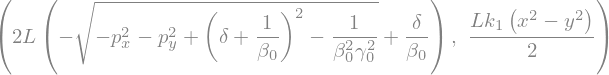

In [6]:
(HamDrift6D(beta0,gamma0,L,x,px,y,py,delta) + HamQuad6D(beta0,gamma0,L,x,px,y,py,delta,k1)).args

In [82]:
A = Function("A", commutative=False)(x,px)
B = Function("B", commutative=False)(x,px)
C = Function("C")(x,px)
D = Function("D")(x,px)
E = Function("E")(x,px)

In [8]:
Aop = LieOperator(A,x,px)
Bop = LieOperator(B,x,px)

In [11]:
PoissonBracket(A,B,[x],[px]).free_symbols

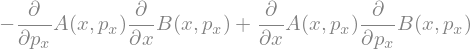

In [21]:
PoissonBracket(A,B,[x],[px]).expr

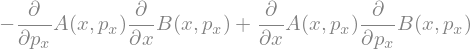

In [24]:
PoissonBracket(A,B,[x],[px])._eval()

In [14]:
Aop

In [16]:
Aop.ham.subs(A,x)

In [17]:
Bop

In [18]:
Aop.BCH(Bop,1)

In [20]:
Aop.BCH(Bop,1).ham

AttributeError: 'Add' object has no attribute 'expr'

In [25]:
Aop.BCH(Bop,2)

In [27]:
Aop.BCH(Bop,2).ham

AttributeError: 'Add' object has no attribute 'eval'

In [170]:
Aop.BCH(Bop,3)

In [171]:
Aop.BCH(Bop,4)

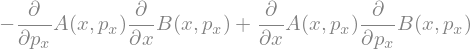

In [172]:
Aop.BCH(Bop,4).ham.args[0].args[1].expr

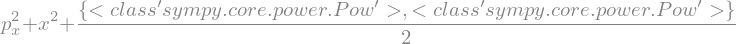

In [188]:
simplify((Aop.BCH(Bop,2).ham.as_expr()).subs(A,x**2).subs(B,px**2).doit())

In [92]:
A.args[0].args

In [203]:
sympy.eval(Aop.BCH(Bop,2).ham.replace(PoissonBracket, lambda arg: arg.expr()))

AttributeError: module 'sympy' has no attribute 'eval'

In [37]:
 def doit(ob, **kwargs):
        print(ob.args)
        if kwargs.get("deep", True):
            return obs.args[0].expr
            return ob.args[0].doit(**kwargs)
        else:
            return ob.args[0].expr

In [48]:
((x+px)**2).expand()

In [41]:
Aop.BCH(Bop,2).ham.func

sympy.core.add.Add

In [38]:
doit(Aop.BCH(Bop,2).ham,deep=False)

(PoissonBracket(A(x, p_x),B(x, p_x),(x,),(p_x,))/2, A(x, p_x), B(x, p_x))


AttributeError: 'Mul' object has no attribute 'expr'

In [201]:
sympy.srepr(Aop.BCH(Bop,2).ham)

"Add(Function('A')(Symbol('x', real=True), Symbol('p_x', real=True)), Function('B')(Symbol('x', real=True), Symbol('p_x', real=True)), Mul(Rational(1, 2), PoissonBracket(Function('A')(Symbol('x', real=True), Symbol('p_x', real=True)),Function('B')(Symbol('x', real=True), Symbol('p_x', real=True)),Tuple(Symbol('x', real=True)),Tuple(Symbol('p_x', real=True)))))"

In [196]:
for arg in sympy.preorder_traversal(Aop.BCH(Bop,2).ham):
    print(arg)

A(x, p_x) + B(x, p_x) + PoissonBracket(A(x, p_x),B(x, p_x),(x,),(p_x,))/2
PoissonBracket(A(x, p_x),B(x, p_x),(x,),(p_x,))/2
1/2
PoissonBracket(A(x, p_x),B(x, p_x),(x,),(p_x,))
A(x, p_x)
x
p_x
B(x, p_x)
x
p_x
(x,)
x
(p_x,)
p_x
A(x, p_x)
x
p_x
B(x, p_x)
x
p_x


In [193]:
sympy.srepr(Aop.BCH(Bop,2).ham

"Add(Function('A')(Symbol('x', real=True), Symbol('p_x', real=True)), Function('B')(Symbol('x', real=True), Symbol('p_x', real=True)), Mul(Rational(1, 2), PoissonBracket(Function('A')(Symbol('x', real=True), Symbol('p_x', real=True)),Function('B')(Symbol('x', real=True), Symbol('p_x', real=True)),Tuple(Symbol('x', real=True)),Tuple(Symbol('p_x', real=True)))))"

In [21]:
import sympy
Aop.BCH(Bop,1).ham.__class__ == sympy.core.add.Add

True

In [70]:
function, *vars = Aop.BCH(Bop,1).ham.doit().args
function, vars

TypeError: (LieOperator(B(x, p_x), [x], [p_x]), ' has to be a Lie Operator')

In [57]:
Aop.BCH(Bop,1)._ham

In [42]:
print_latex(Aop.BCH(Bop,1)._ham)

A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)}


In [20]:
Aop.BCH(Bop,1).args[0]

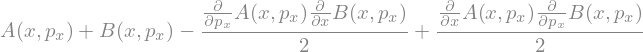

In [21]:
Aop.BCH(Bop,2).args[0]

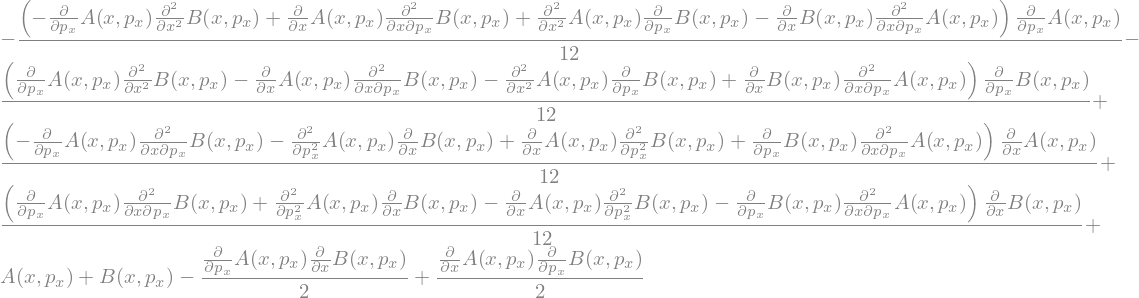

In [23]:
Aop.BCH(Bop,3).args[0]

In [103]:
from sympy.physics.quantum import Operator
from sympy.printing.pretty.stringpict import prettyForm
from sympy.printing.latex import print_latex

class PoissonBracket(Operator):
    _is_commutative = False
    
    def __init__(self, *args):
        if not len(args) == 4:
            raise ValueError('4 parameters expected, got %s' % args)

        self.A = args[0] 
        self.B = args[1]
        self.indep_coords = args[2]
        self.indep_mom    = args[3]
        
        
    @property
    def free_symbols(self):
        return self.A.free_symbols.union(self.B.free_symbols)
    
    @property
    def expr(self):
        hp = S(0)
        for qi, pi in zip(self.indep_coords, self.indep_mom):
            hp += self.A.diff(qi) * self.B.diff(pi)
            hp -= self.A.diff(pi) * self.B.diff(qi)
        return hp
    
    def _eval_derivative(self, symbol):
        new_expr = self.expr.diff(symbol)
        return new_expr
    def _evalf(self):
        return self.expr
        return new_expr
    def _latex(self, printer=None):
        a,b = [printer.doprint(i) if i.__class__.__name__ == self.__class__.__name__ else printer.doprint(i.func) for i in self.args[:2]]
        print_latex(a)
        print_latex(b)
        return r"\lbrace {}, {} \rbrace".format(a,b)
    
   


In [104]:
apb =PoissonBracket(A,B,[x],[px])

In [95]:
print(apb)

PoissonBracket(A(x, p_x),B(x, p_x),(x,),(p_x,))


In [96]:
apb

A
B
A
B


In [97]:
print_latex(apb)

A
B
\lbrace A, B \rbrace


A
B
A
B


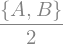

In [105]:
(Rational(1,2)*apb.evalf()).as_expr()

In [184]:
print_latex(apb.expr)

- \frac{\partial}{\partial p_{x}} A{\left(x,p_{x} \right)} \frac{\partial}{\partial x} B{\left(x,p_{x} \right)} + \frac{\partial}{\partial x} A{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} B{\left(x,p_{x} \right)}


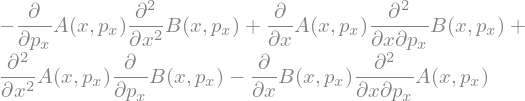

In [185]:
apb.diff(x)

In [186]:
apbpc = PoissonBracket(C,apb,[x],[px])

In [187]:
apbpc

A
B
C
\lbrace A, B \rbrace
A
B
C
\lbrace A, B \rbrace


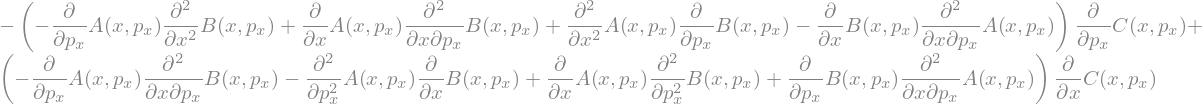

In [188]:
apbpc.expr

A
B
A
B
A
B
A
B


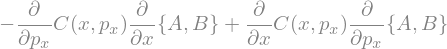

In [175]:
apbpc.expr.expand()

In [162]:
A.__class__.__name__

'A'

In [641]:
A = Function("A")

A(x)._hashable_content()

In [636]:
list(set(A._hashable_content() +B._hashable_content()))

In [643]:
from __future__ import print_function, division

from sympy import S, Expr, Mul,Add, Pow
from sympy.physics.quantum import Operator
from sympy.printing.latex import print_latex
from sympy.printing.pretty.stringpict import prettyForm


from sympy import S, Expr, Mul, Add, Pow
from sympy.printing.pretty.stringpict import prettyForm

from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum.operator import Operator

from sympy.core.decorators import _sympifyit, call_highest_priority

class PoissonBracket(Expr):
    """
    Operator class for the Poisson Bracket - allows to have it as a symbolic operator
    """
    
    _op_priority = 11.0
    _is_commutative = False
    
    def __new__(cls,A,B,indep_coords, indep_mom):
         # create list of coords
        if not isinstance(indep_coords, list):
            indep_coords = [indep_coords]

        # create list of momenta
        if not isinstance(indep_mom, list):
            indep_mom = [indep_mom]

        # same number of coordinates and momenta have to be entered
        assert len(indep_coords) == len(
            indep_mom
        ), "The number of coords and momenta is not the same"
        
        r=cls.eval(A,B, indep_coords, indep_mom)
        if r is not None:
            return r
        obj = Expr.__new__(cls,A,B,indep_coords, indep_mom)
        obj.A = A
        obj.B = B
        obj.indep_coords = indep_coords
        obj.indep_mom = indep_mom
        return obj
    
    @classmethod
    def eval(cls,a,b,indep_coords,indep_mom):
        if not (a and b):
#             print("here")
            return S.Zero
        if a==b:
            print("here")
            print(a,b)
            return S.Zero
#         if a.compare(b) ==1:
#             return S.NegativeOne*cls(b,a,indep_coords,indep_mom)
        
    @property
    def free_symbols(self):
        return self.A.free_symbols.union(self.B.free_symbols)
    
    @property
    def expr(self):
        hp = S(0)
        for qi, pi in zip(self.indep_coords, self.indep_mom):
            hp += self.A.diff(qi) * self.B.diff(pi)
            hp -= self.A.diff(pi) * self.B.diff(qi)
        return hp

    def _eval_derivative(self, symbol):
        """
        Necessary to get the full expanded expression
        when one of the arguments is itself a PoissonBracket.
        In other words to allow evalutation of nested Poisson Brackets.
        """
        new_expr = self.expr.diff(symbol)
        return new_expr
    
    def doit(self, **hints):
        """ Evaluate commutator """
        A = self.args[0]
        B = self.args[1]
        if isinstance(A, Operator) and isinstance(B, Operator):
            try:
                comm = A._eval_commutator(B, **hints)
            except NotImplementedError:
                try:
                    comm = -1*B._eval_commutator(A, **hints)
                except NotImplementedError:
                    comm = None
            if comm is not None:
                return comm.doit(**hints)
            
        hp = self.expr
        return hp.doit(**hints)
#         return (A*B - B*A).doit(**hints)

    def _eval_expand_commutator(self, **hints):
        A = self.A #self.args[0]
        B = self.B #self.args[1]

        if isinstance(A, Add):
            # [A + B, C]  ->  [A, C] + [B, C]
            sargs = []
            for term in A.args:
                comm = PoissonBracket(term, B,self.indep_coords, self.indep_mom)
                print(comm.__class__)
                if isinstance(comm, PoissonBracket):
                    comm = comm._eval_expand_commutator()
                sargs.append(comm)
            print(sargs)
            return Add(*sargs)
        
        
        return self
    
    # Define Addition
    @_sympifyit("other", NotImplemented)
    @call_highest_priority("__radd__")
    def __add__(self,other):
        if self.A == other.A:
            return PoissonBracket(self.A, self.B+other.B,self.indep_coords,self.indep_mom)
        elif self.B == other.B:
            return PoissonBracket(self.A+other.A,self.B, self.indep_coords,self.indep_mom)
        return self
    
    def _latex(self, printer, *args):
#         print(tuple([
#             printer._print(arg.func, *args) if arg.__class__.__name__ != "PoissonBracket" else  printer._print(arg, *args) for arg in self.args[:2] ]))
        news = []
        for arg in self.args[:2]:
#             print(type(arg))
            if isinstance(arg,Add):
                news.append(" + ".join([printer._print(a.func, *args) if a.is_Function  else  printer._print(a, *args) for a in arg.args]))
            elif isinstance(arg,PoissonBracket):
                news.append("\\lbrace %s,%s\\rbrace" %tuple([
            printer._print(a.func, *args) if a.is_Function  else  printer._print(a, *args) for a in arg.args[:2] ]))
            elif isinstance(arg,Mul):
                news.append([ printer._print(arg, *args) for arg in self.args[:2] ])
            elif isinstance(arg, Function):
                news.append(printer._print(arg.func, *args))
#         print(news)
#         return "\\lbrace %s,%s\\rbrace" %tuple(news)
        
        return "\\lbrace %s,%s\\rbrace" %tuple([
            printer._print(arg.func, *args) if arg.is_Function  else  printer._print(arg, *args) for arg in self.args[:2] ])
#         return "\\lbrace %s,%s\\rbrace" % tuple([
#             printer._print(arg, *args) for arg in self.args[:2]])

In [607]:
Commutator(G+H,I).expand(commutator=True)

<class '__main__.Commutator'>
<class '__main__.Commutator'>
[[G,I], [H,I]]


In [491]:
A = Function("A")(x,px)
B = Function("B")(x,px)
C = Function("C")(x,px)
D = Function("D")(x,px)
E = Function("E")(x,px)

In [569]:
G = Operator("G")
H = Operator("H")
I = Operator("I")

In [644]:
p1,p2 = (PoissonBracket(A,B,x,px),PoissonBracket(C,B,x,px))

In [611]:
PoissonBracket(A+B,C,x,px).expand(commutator=True)

<class '__main__.PoissonBracket'>
<class '__main__.PoissonBracket'>
[PoissonBracket(A(x, p_x), C(x, p_x), [x], [p_x]), PoissonBracket(B(x, p_x), C(x, p_x), [x], [p_x])]


TypeError: unhashable type: 'list'

In [492]:
PoissonBracket(A,B,x,px)

In [493]:
PoissonBracket(A,B,x,px).free_symbols

In [591]:
PoissonBracket(A,B,x,px) + PoissonBracket(A,C,x,px)

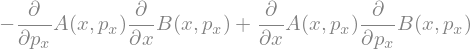

In [494]:
PoissonBracket(A,B,x,px).doit()

In [495]:
lev2 = PoissonBracket(PoissonBracket(A,B,x,px),C,x,px)
lev2

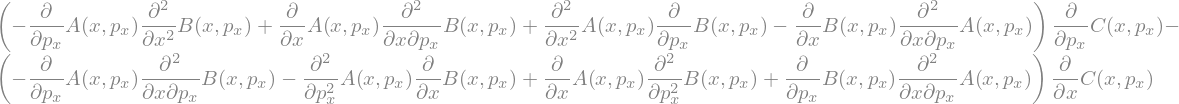

In [496]:
lev2.doit()

In [497]:
lev3 = PoissonBracket(lev2,D,x,px)#|.doit()
lev3

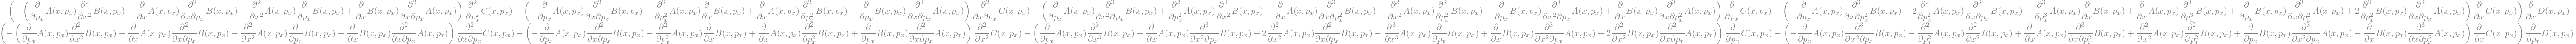

In [498]:
lev3doit = lev3.doit()
lev3doit

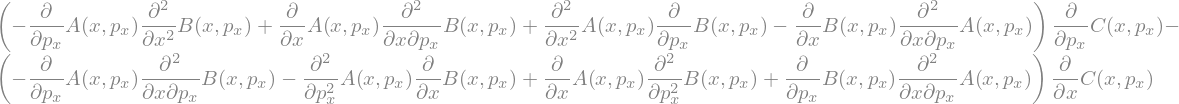

In [499]:
lev2doit = lev2.doit()
lev2doit

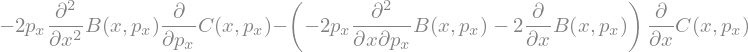

In [500]:
lev2doit.subs(A,px**2).doit()

In [567]:
(PoissonBracket(A, C, [x], [px])+ PoissonBracket(B, C, [x], [px])).__class__

__main__.PoissonBracket

In [568]:
(A+B).__class__

sympy.core.add.Add

In [570]:
(G+H).__class__

sympy.core.add.Add

In [572]:
A+B

In [571]:
G+H

In [563]:
sargs =[PoissonBracket(A, C, [x], [px]), PoissonBracket(B, C, [x], [px])]
Add(*sargs)

TypeError: unhashable type: 'list'

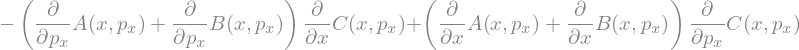

In [521]:
pbadd = PoissonBracket(A+B,C,x,px)
pbadd, pbadd.expand(commutator=True)

PoissonBracket(A(x, p_x), C(x, p_x), [x], [p_x])
PoissonBracket(B(x, p_x), C(x, p_x), [x], [p_x])
[PoissonBracket(A(x, p_x), C(x, p_x), [x], [p_x]), PoissonBracket(B(x, p_x), C(x, p_x), [x], [p_x])]


TypeError: unhashable type: 'list'

In [342]:
from __future__ import print_function, division

from sympy import S, Expr, Mul,Add, Pow
from sympy.physics.quantum import Operator
from sympy.printing.latex import print_latex
from sympy.printing.pretty.stringpict import prettyForm


from sympy import S, Expr, Mul, Add, Pow
from sympy.printing.pretty.stringpict import prettyForm

from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum.operator import Operator
class PoissonBracket(Expr):
    """
    Operator class for the Poisson Bracket - allows to have it as a symbolic operator
    """

    _is_commutative = False
    
    def __new__(cls,A,B,indep_coords, indep_mom):
        # create list of coords
        if not isinstance(indep_coords, list):
            indep_coords = [indep_coords]

        # create list of momenta
        if not isinstance(indep_mom, list):
            indep_mom = [indep_mom]

        # same number of coordinates and momenta have to be entered
        assert len(indep_coords) == len(
            indep_mom
        ), "The number of coords and momenta is not the same"
        
        r=cls.eval(A,B, indep_coords, indep_mom)
        if r is not None:
            return r
        obj = Expr.__new__(cls,A,B,indep_coords, indep_mom)
        obj.A = A
        obj.B = B
        obj.indep_coords = indep_coords
        obj.indep_mom = indep_mom
        return obj

    @classmethod
    def eval(cls,a,b,indep_coords,indep_mom):
        if not (a and b):
#             print("here")
            return S.Zero
        if a==b:
            print("here")
            print(a,b)
            return S.Zero
        
        # {xA,yB} = xy{A,B}
        ca, nca = a.args_cnc()
        cb, ncb = b.args_cnc()
        print(ca, nca)
        print(cb, ncb)
        c_part=ca+cb
        if c_part:
            return Mul(Mul(*c_part), cls(Mul._from_args(nca), Mul._from_args(ncb), indep_coords, indep_mom))
        
        if a.compare(b) ==1:
            return S.NegativeOne*cls(b,a,indep_coords,indep_mom)
        
    def doit(self, **hints):
        """ Evaluate commutator """
        A = self.args[0]
        B = self.args[1]
        if isinstance(A, Operator) and isinstance(B, Operator):
            try:
                comm = A._eval_commutator(B, **hints)
            except NotImplementedError:
                try:
                    comm = -1*B._eval_commutator(A, **hints)
                except NotImplementedError:
                    comm = None
            if comm is not None:
                return comm.doit(**hints)
            
        hp = S(0)
        for qi, pi in zip(self.indep_coords, self.indep_mom):
            hp += self.A.diff(qi) * self.B.diff(pi)
            hp -= self.A.diff(pi) * self.B.diff(qi)
        return hp.doit(**hints)
        return (A*B - B*A).doit(**hints)
    
    def _expand_pow(self, A, B, sign):
        exp = A.exp
        if not exp.is_integer or not exp.is_constant() or abs(exp) <= 1:
            # nothing to do
            return self
        base = A.base
        if exp.is_negative:
            base = A.base**-1
            exp = -exp
        comm = PoissonBracket(base, B).expand(commutator=True)

        result = base**(exp - 1) * comm
        for i in range(1, exp):
            result += base**(exp - 1 - i) * comm * base**i
        return sign*result.expand()
    
    def _eval_expand_commutator(self, **hints):
        A = self.args[0]
        B = self.args[1]

        if isinstance(A, Add):
            # [A + B, C]  ->  [A, C] + [B, C]
            sargs = []
            for term in A.args:
                comm = PoissonBracket(term, B,self.indep_coords, self.indep_mom)
                print(comm)
                if isinstance(comm, PoissonBracket):
                    comm = comm._eval_expand_commutator()
                sargs.append(comm)
            print(sargs)
            return Add(*sargs)
        elif isinstance(B, Add):
            # [A, B + C]  ->  [A, B] + [A, C]
            sargs = []
            for term in B.args:
                comm = PoissonBracket(A, term, self.indep_coords, self.indep_mom)
                if isinstance(comm, PoissonBracket):
                    comm = comm._eval_expand_commutator()
                sargs.append(comm)
            return Add(*sargs)
        elif isinstance(A, Mul):
            # [A*B, C] -> A*[B, C] + [A, C]*B
            a = A.args[0]
            b = Mul(*A.args[1:])
            c = B
            comm1 = PoissonBracket(b, c,self.indep_coords,self.indep_mom)
            comm2 = PoissonBracket(a, c,self.indep_coords,self.indep_mom)
            if isinstance(comm1, PoissonBracket):
                comm1 = comm1._eval_expand_commutator()
            if isinstance(comm2, PoissonBracket):
                comm2 = comm2._eval_expand_commutator()
            first = Mul(a, comm1)
            second = Mul(comm2, b)
            return Add(first, second)
        elif isinstance(B, Mul):
            # [A, B*C] -> [A, B]*C + B*[A, C]
            a = A
            b = B.args[0]
            c = Mul(*B.args[1:])
            comm1 = PoissonBracket(a, b,self.indep_coords,self.indep_mom)
            comm2 = PoissonBracket(a, c,self.indep_coords,self.indep_mom)
            if isinstance(comm1, PoissonBracket):
                comm1 = comm1._eval_expand_commutator()
            if isinstance(comm2, PoissonBracket):
                comm2 = comm2._eval_expand_commutator()
            first = Mul(comm1, c)
            second = Mul(b, comm2)
            return Add(first, second)
        elif isinstance(A, Pow):
            # [A**n, C] -> A**(n - 1)*[A, C] + A**(n - 2)*[A, C]*A + ... + [A, C]*A**(n-1)
            return self._expand_pow(A, B, 1)
        elif isinstance(B, Pow):
            # [A, C**n] -> C**(n - 1)*[C, A] + C**(n - 2)*[C, A]*C + ... + [C, A]*C**(n-1)
            return self._expand_pow(B, A, -1)

        # No changes, so return self
        return self
    
    def _sympyrepr(self, printer, *args):
        return "%s(%s,%s)" % (
            self.__class__.__name__, printer._print(
                self.args[0]), printer._print(self.args[1])
        )

    def _sympystr(self, printer, *args):
        return "[%s,%s]" % (self.args[0], self.args[1])

    def _pretty(self, printer, *args):
        pform = printer._print(self.args[0], *args)
        pform = prettyForm(*pform.right((prettyForm(u','))))
        pform = prettyForm(*pform.right((printer._print(self.args[1], *args))))
        pform = prettyForm(*pform.parens(left='[', right=']'))
        return pform
    
    def _latex(self, printer, *args):
        return "\\lbrace %s,%s\\rbrace" % tuple([
            printer._print(arg, *args) for arg in self.args[:2]])
    
#     def __init__(self, *args):
#         if not len(args) == 4:
#             raise ValueError("4 parameters expected, got %s" % args)

#         self.A = args[0]
#         self.B = args[1]
#         self.indep_coords = args[2]
#         self.indep_mom = args[3]

#     @property
#     def free_symbols(self):
#         return self.A.free_symbols.union(self.B.free_symbols)

#     @property
#     def expr(self):
#         hp = S(0)
#         for qi, pi in zip(self.indep_coords, self.indep_mom):
#             hp += self.A.diff(qi) * self.B.diff(pi)
#             hp -= self.A.diff(pi) * self.B.diff(qi)
#         return hp

#     def _eval_derivative(self, symbol):
#         """
#         Necessary to get the full expanded expression
#         when one of the arguments is itself a PoissonBracket.
#         In other words to allow evalutation of nested Poisson Brackets.
#         """
#         new_expr = self.expr.diff(symbol)
#         return new_expr

#     def _eval(self):
#         return self.expr

#     def _latex(self, printer=None):
#         a, b = [
#             printer.doprint(i)
#             if i.__class__.__name__ == self.__class__.__name__
#             else printer.doprint(i.func)
#             for i in self.args[:2]
#         ]
#         return r"\lbrace {}, {} \rbrace".format(a, b)


In [244]:
PoissonBracket(Operator("I")+Operator("G"),Operator("H"),x,px).expand(commutator=True)

[] [G + I]
[] [H]
[] [G]
[] [H]
[G,H]
[] [I]
[] [H]
[] [H]
[] [I]
-[H,I]
[[G,H], -[H,I]]


TypeError: unhashable type: 'list'

In [248]:
Add([PoissonBracket(Operator("G"),Operator("H"),x,px), -PoissonBracket(Operator("H"),Operator("I"),x,px)])

[] [G]
[] [H]
[] [H]
[] [I]


SympifyError: SympifyError: [[G,H], -[H,I]]

In [236]:
C = PoissonBracket(A,B,x,px)

[] [A(x, p_x)]
[] [B(x, p_x)]


In [237]:
C

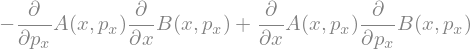

In [238]:
C.doit()

In [239]:
PoissonBracket(3*x*A,x*y*B,x,px)

[3, x] [A(x, p_x)]
[x, y] [B(x, p_x)]
[] [A(x, p_x)]
[] [B(x, p_x)]


In [240]:
D= Function("D",commutative=False)(x,px)

In [241]:
PoissonBracket(D+A,B,x,px).expand(commutator=True)

[] [A(x, p_x) + D(x, p_x)]
[] [B(x, p_x)]
[] [A(x, p_x)]
[] [B(x, p_x)]
[A(x, p_x),B(x, p_x)]
[] [D(x, p_x)]
[] [B(x, p_x)]
[] [B(x, p_x)]
[] [D(x, p_x)]
-[B(x, p_x),D(x, p_x)]
[[A(x, p_x),B(x, p_x)], -[B(x, p_x),D(x, p_x)]]


TypeError: unhashable type: 'list'